In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import os,glob,scienceplots
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.font_manager as font_manager
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica.ttf')
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica-Bold.ttf')
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

### identify drought-to-flood events

In [8]:
def cleanQ(df):
    # eliminate invalid records
    df1 = df.loc[df.Q.apply(lambda x: not isinstance(x, str)),:]
    df2 = df.loc[df.Q.apply(lambda x: isinstance(x, str)),:]
    try:
        df2 = df2.loc[df2.Q.str.match('\d+'),:]
    except:
        pass
    df = pd.concat([df1, df2])
    df['Q'] = df.Q.astype(np.float32)
    return df

def del_unreliableQ(df):
    '''observations less than 0 were flagged as
        suspected, and (b) observations with more than ten consecutive
        equal values greater than 0 were flagged as suspected'''
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')
    index = pd.date_range(df.index[0], df.index[-1], freq = 'D')
    df = df.reindex(index)
    df1 = df.fillna(0).diff()
    df1 = df1.where(df1==0, 1).diff()
    start = np.where(df1.values==-1)[0]
    end = np.where(df1.values==1)[0]
    if len(start) == 0 or len(end) == 0:
        # must no less than zero
        df = df.loc[df.Q>=0,:]
        return (df)
    if start[0] > end[0]:
        start = np.array([0]+start.tolist())
    if start[-1] > end[-1]:
        end = np.array(end.tolist()+[df1.shape[0]+10])
    duration = end - start
    start = start[duration>=10]
    end = end[duration>=10]
    del_idx = np.array([item for a,b in zip(start,end) for item in np.arange(a+1,b+2).tolist()])
    del_idx = del_idx[del_idx<df.shape[0]]
    # identical values should be greater than zero
    del_idx = [s for s in del_idx if df.iloc[s,:].Q > 0]
    if len(del_idx) > 0:
        df.drop(df.index[del_idx], inplace = True)
    # must no less than zero
    df = df.loc[df.Q>=0,:]
    return (df)

def del_outlierQ(df):
    '''
        Based on a previously suggested approach for evaluating temperature series (Klein Tank et al., 2009), 
        daily streamflow values are declared as outliers if values of log (Q+0.01) are larger or smaller than 
        the mean value of log (Q+0.01) plus or minus 6 times the standard deviation of log (Q+0.01) computed for 
        that calendar day for the entire length of the series. The mean and standard deviation are computed for 
        a 5-day window centred on the calendar day to ensure that a sufficient amount of data is considered. 
        The log-transformation is used to account for the skewness of the distribution of daily streamflow values 
        and 0.01 was added because the logarithm of zero is undefined. Outliers are flagged as suspect. 
        The rationale underlying this rule is that unusually large or small values are often associated with observational issues. 
        The 6 standard-deviation threshold is a compromise, aiming at screening out outliers that could come from 
        instrument malfunction, while not flagging extreme floods or low flows.
    '''
    df['logQ'] = np.log(df['Q']+0.01)
    df['doy'] = df.index.dayofyear
    df['year'] = df.index.year
    df = df.pivot_table(index = 'doy', columns = 'year', values = 'logQ').reset_index()
    def tmp(x0):
        x = np.arange(x0-2, x0+3) 
        x = np.where(x <= 0, x + 366, x)
        x = np.where(x > 366, x - 366, x)
        s = df.loc[df.doy.isin(x),:].drop(columns=['doy']).values.flatten()
        ave = np.nanmean(s)
        std = np.nanstd(s)
        low = ave - std * 6
        upp = ave + std * 6
        return (x0, low, upp)
    thres = list(map(tmp, np.arange(1, 367)))
    thres = pd.DataFrame(data = np.array(thres), columns = ['doy','low','upp'])
    df = df.merge(thres, on = 'doy').set_index('doy')
    df.iloc[:,:(df.shape[1]-2)] = df.iloc[:,:(df.shape[1]-2)].where(df.iloc[:,:(df.shape[1]-2)].lt(df['upp'], axis=0))
    df.iloc[:,:(df.shape[1]-2)] = df.iloc[:,:(df.shape[1]-2)].where(df.iloc[:,:(df.shape[1]-2)].gt(df['low'], axis=0))
    df = df.drop(columns = ['low','upp']).stack().reset_index(name='logQ')
    df['Q'] = np.exp(df['logQ']) - 0.01
    df['Q'] = np.where(df['Q'].abs()<1e-6, 0, df['Q'])
    df['date'] = pd.to_datetime(df['level_1'].astype(str) + '-' + df['doy'].astype(str), format='%Y-%j')
    df = df[['date','Q']].sort_values('date').set_index('date')
    return df

def identify_drought(df, q = 0.2, scale = '30D', d = 30):
    # 30 days moving average of the flow to avoid identifying minor drought events
    df30 = df.rolling(scale).mean()

    # variable drought threshold: the 20th flow percentile of the averaged flow for each day of the year with a 30-day window
    df30['doy'] = df30.index.dayofyear
    df30['year'] = df30.index.year
    df30 = df30.pivot_table(index='doy', columns = 'year', values = 'Q')
    df30 = df30.reindex(np.arange(df30.index.values[0], df30.index.values[-1]+1, 1))
    min_idx = df30.index.values[0]
    thres = df30.apply(
        lambda x:df30.loc[(max(0,int(x.name)-15)):(int(x.name)+16)].stack().quantile(q), 
        axis = 1)
    df30 = df30.apply(lambda x:np.where(x<=thres, x, np.nan), axis = 0)
    df30 = df30.stack().reset_index().rename(
        columns={0:'dis30'}).sort_values(['year','doy']).reset_index(drop=True)
    
    # identify drought event using run theory
    df30.index = df30[['year','doy']].apply(
        lambda x:pd.to_datetime('%d-1-1'%x.year)+pd.Timedelta(days=x.doy-1),axis = 1
    )
    df30 = df30.reindex(pd.date_range(df30.index[0], df30.index[-1], freq='D'))
    df30 = df30.reset_index(names='date')
    df30 = df30.merge(pd.DataFrame(thres, columns = ['thres']), left_on = 'doy', right_index = True, how = 'left')
    df30['deficit'] = df30['thres'] - df30['dis30']
    
    indices = np.where(df30.dis30>=0, 1, 0)
    start = np.where(np.diff(indices)==1)[0] + 1
    end = np.where(np.diff(indices)==-1)[0]
    if len(start) == 0 or len(end) == 0:
        return pd.DataFrame(columns = ['id','start','end','duration','deficit']), None
    if start[0] > end[0]:
        start = np.array([0]+start.tolist())
    if start[-1] > end[-1]:
        end = np.array(end.tolist()+[indices.shape[0]+10])

    # calculate drought deficit as accumulative difference between dis30 and threshold
    deficit = np.array([df30.iloc[a:(b+1),:].deficit.sum() for a,b in zip(start,end)])
    end = np.where(end >= df30.shape[0], df30.shape[0] -1, end)
    duration = end - start + 1
    start = df30.iloc[start,:].date.values
    end = df30.iloc[end,:].date.values
    drought = pd.DataFrame({
        'id': np.arange(len(start)),
        'start': start,
        'end': end,
        'duration': duration,
        'deficit': deficit
    })
    # drought lasting at least 30 days (duration)
    drought = drought.loc[drought.duration>=d,:]
    # deficit larger than zero
    drought = drought.loc[drought.deficit>0,:]
    # thres
    thres = df30.groupby('doy').thres.apply(lambda x:x.iloc[0]).reset_index()
    return drought, thres

def identify_flood_Brunner(df, q = 0.5, min_time_lag = 10):
    # threshold: 50th percentile of annual maximum discharge
    df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq = 'D'))
    thres = df.dropna().resample('Y').Q.max().quantile(q)
    df = df.reset_index(names=['date'])
    indices = np.where(df.Q>=thres, 1, 0)
    start = np.where(np.diff(indices)==1)[0] + 1
    end = np.where(np.diff(indices)==-1)[0]
    if len(start) == 0 or len(end) == 0:
        return pd.DataFrame(columns = ['id','start','end','duration','totalQ','maxQ']), None
    if start[0] > end[0]:
        start = np.array([0]+start.tolist())
    if start[-1] > end[-1]:
        end = np.array(end.tolist()+[indices.shape[0]+10])
    # calculate drought deficit as accumulative difference between dis30 and threshold
    totalQ = np.array([df.iloc[a:(b+1),:].Q.sum() for a,b in zip(start,end)])
    maxQ = np.array([df.iloc[a:(b+1),:].Q.max() for a,b in zip(start,end)])
    
    end = np.where(end >= df.shape[0], df.shape[0] -1, end)
    duration = end - start + 1
    start = df.iloc[start,:].date.values
    end = df.iloc[end,:].date.values
    
    flood = pd.DataFrame({
        'id': np.arange(len(start)),
        'start': start,
        'end': end,
        'duration': duration,
        'totalQ': totalQ,
        'maxQ': maxQ
    })
    
    # event independence min_time_lag = 10 days
    nrow = flood.shape[0]
    while True:
        del_idx = []
        for i in range(1, flood.shape[0]):
            a = flood.iloc[i,:]
            b = flood.iloc[i-1,:]
            lag = (a.start - b.end).days
            if lag >= min_time_lag:
                continue
            if a.maxQ > b.maxQ:
                del_idx.append(i-1)
            else:
                del_idx.append(i)
        flood = flood.drop(del_idx).reset_index(drop=True)
        if flood.shape[0] == nrow:
            break
        nrow = flood.shape[0]
    
    return flood, thres

def identify_flood_USGS(df, Darea):
    Q = df.Q.values
    peak_idx, _ = find_peaks(Q)
    peak_idx = np.array([s for s in peak_idx if Q[s]>0])
    # thres
    thres = 5 + np.log(Darea * 0.386102) 
    peak_idx = np.array([peak_idx[0]] + peak_idx[1:][np.diff(peak_idx)>=thres].tolist())
    while True:
        to_delete = []
        for i,peak_idx0 in enumerate(peak_idx[:-1]):
            peak1 = Q[peak_idx0]
            peak2 = Q[peak_idx[i+1]]
            minQ = Q[peak_idx0:(peak_idx[i+1])].min()
            min_peak = min(peak1, peak2)
            if minQ / min_peak < 0.75:
                continue
            if peak1 < peak2:
                to_delete.append(peak_idx0)
            else:
                to_delete.append(peak_idx[i+1])
        if len(to_delete) == 0:
            break
        peak_idx = np.array(list(set(peak_idx)-set(to_delete)))
        peak_idx.sort()
    flood = df.iloc[peak_idx,:]
    return flood

def drought2flood(drought, flood):
    drought = drought.sort_values('start').reset_index(drop=True)
    flood = flood.sort_values('start').reset_index(drop=True)
    drought['d2f'] = -1
    flood['d2f'] = -1
    drought['id'] = np.arange(drought.shape[0])
    flood['id'] = np.arange(flood.shape[0])
    nd = drought.shape[0]
    for row in np.arange(nd):
        d0 = drought.iloc[row,:]
        flood['lag'] = (flood.start-d0.start).dt.days
        f0 = flood.loc[flood.lag>=0,:].sort_values('lag')
        if f0.shape[0] > 0:
            f0 = f0.iloc[0,:]
        else:
            continue
        if row + 1 == nd:
            continue
        drought1 = drought.iloc[(row+1):,:]
        if drought1.loc[(drought1.start>d0.start)&(drought1.start<f0.start),:].shape[0] > 0:
            continue
        drought.loc[drought.index==row,'d2f'] = f0.id
    d2f = pd.concat([drought, flood])
    if 'lag' in d2f.columns:
        d2f = d2f.drop(columns=['lag'])
    return d2f

def main(ohdb_id, darea = None):
    fname = f'../data/OHDB/OHDB_v0.2.3/OHDB_data/discharge/daily/{ohdb_id}.csv'
    df = pd.read_csv(fname)
    df = cleanQ(df)
    df = del_unreliableQ(df)
    df = del_outlierQ(df)
    # at least 20 years data for 1982-2023, at least 300 observations per year
    df = df.loc[(df.index.year>=1982)&(df.index.year<=2023),:]
    if df.shape[0] == 0:
        return
    tmp = df.resample('Y').Q.count()
    years = tmp.loc[tmp>=300].index.year
    if len(years) < 20:
        return
    df = df.loc[df.index.year.isin(years),:]
    drought, thresD = identify_drought(df)
    drought = drought.rename(columns={'deficit':'magnitude'}).assign(event='drought')
    # flood = identify_flood_USGS(df, darea)
    flood, thresF = identify_flood_Brunner(df)
    flood = flood.rename(columns={'totalQ':'magnitude'}).assign(event='flood').drop(columns=['maxQ'])
    event = drought2flood(drought, flood)
    event['ohdb_id'] = ohdb_id
    return event
    
if __name__ == '__main__':
    df_attr = pd.read_csv('GRIT_basin_boundary_darea.csv')
    df_attr = df_attr.loc[np.abs(df_attr.grit_darea-df_attr.ohdb_darea_hydrosheds)/df_attr.ohdb_darea_hydrosheds<=0.2,:]
    tmp = pd.read_csv('../data/OHDB/OHDB_v0.2.3/OHDB_metadata/OHDB_metadata.csv')
    df_attr = df_attr.merge(tmp[['ohdb_id','ohdb_longitude','ohdb_latitude']], on = 'ohdb_id')
    df_attr = df_attr.dropna(subset=['ohdb_longitude','ohdb_latitude'])

    with mp.Pool(processes=24) as pool:
         events = list(tqdm(pool.imap_unordered(main, df_attr.ohdb_id.values), total=len(df_attr.ohdb_id.values)))
    
    events = pd.concat(events)
    events.to_csv('drought_to_flood_1982-2023.csv', index = False)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30266/30266 [18:13<00:00, 27.67it/s]


In [33]:
def get_year(ohdb_id):
    fname = f'../data/OHDB/OHDB_v0.2.3/OHDB_data/discharge/daily/{ohdb_id}.csv'
    df = pd.read_csv(fname)
    df = cleanQ(df)
    df = del_unreliableQ(df)
    df = del_outlierQ(df)
    # at least 20 years data for 1982-2023, at least 300 observations per year
    df = df.loc[(df.index.year>=1982)&(df.index.year<=2023),:]
    if df.shape[0] == 0:
        return
    tmp = df.resample('Y').Q.count()
    years = tmp.loc[tmp>=300].index.year
    if len(years) < 20:
        return
    return pd.DataFrame({'year':years,'ohdb_id':ohdb_id})

if __name__ == '__main__':
    df_attr = pd.read_csv('GRIT_basin_boundary_darea.csv')
    df_attr = df_attr.loc[np.abs(df_attr.grit_darea-df_attr.ohdb_darea_hydrosheds)/df_attr.ohdb_darea_hydrosheds<=0.2,:]
    tmp = pd.read_csv('../data/OHDB/OHDB_v0.2.3/OHDB_metadata/OHDB_metadata.csv')
    df_attr = df_attr.merge(tmp[['ohdb_id','ohdb_longitude','ohdb_latitude']], on = 'ohdb_id')
    df_attr = df_attr.dropna(subset=['ohdb_longitude','ohdb_latitude'])

    with mp.Pool(processes=24) as pool:
         event_year = list(tqdm(pool.imap_unordered(get_year, df_attr.ohdb_id.values), total=len(df_attr.ohdb_id.values)))
    
    event_year = [a for a in event_year if a is not None]
    event_year = pd.concat(event_year)
    event_year.to_csv('number_stations_per_year.csv', index = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30266/30266 [08:30<00:00, 59.29it/s]


### an example of drought-to-flood identification

    id      start        end  duration  magnitude    event  d2f
0    0 1962-06-19 1962-08-06        49   0.855913  drought   -1
1    1 1963-01-01 1963-03-05        64  10.445320  drought    0
2    2 1964-01-30 1964-03-13        44   5.197887  drought   -1
3    3 1964-08-26 1965-01-17       145   8.876373  drought    1
4    4 1970-05-15 1970-07-27        74   2.051280  drought   -1
5    5 1970-10-07 1970-11-06        31   0.404593  drought    7
6    6 1972-10-08 1972-12-06        60   0.807240  drought   -1
7    7 1973-01-07 1973-02-17        42   4.572013  drought   -1
8    8 1973-02-20 1973-05-13        83  20.789087  drought   -1
9    9 1974-04-27 1974-07-12        77   3.908587  drought   -1
10  10 1975-03-21 1975-04-30        41   2.374026  drought   -1
11  11 1975-07-12 1975-09-07        58   0.552653  drought   -1
12  12 1975-11-02 1976-05-29       210  30.238161  drought   -1
13  13 1976-07-11 1976-09-11        63   2.923720  drought   10
14  14 1977-09-03 1977-10-20        48  

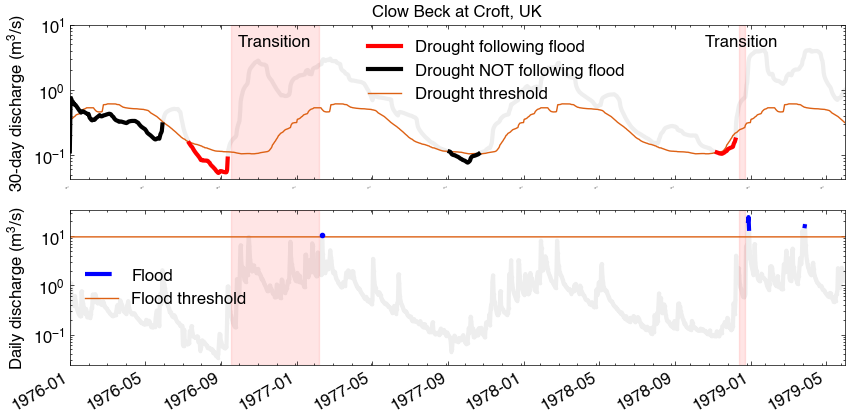

In [6]:
# identify drought-to-flood transition event
df_attr = pd.read_csv('GRIT_basin_boundary_darea.csv')
df_attr = df_attr.loc[np.abs(df_attr.grit_darea-df_attr.ohdb_darea_hydrosheds)/df_attr.ohdb_darea_hydrosheds<=0.2,:]

ohdb_id = df_attr.ohdb_id.values[5000]
fname = f'../data/OHDB/OHDB_v0.2.3/OHDB_data/discharge/daily/{ohdb_id}.csv'

df = pd.read_csv(fname)
df = cleanQ(df)
df = del_unreliableQ(df)
df = del_outlierQ(df)
drought, thresD = identify_drought(df)
drought = drought.rename(columns={'deficit':'magnitude'}).assign(event='drought')
# flood = identify_flood_USGS(df, darea)
flood, thresF = identify_flood_Brunner(df)
flood = flood.rename(columns={'totalQ':'magnitude'}).assign(event='flood').drop(columns=['maxQ'])
event = drought2flood(drought, flood)
print(event)

# plot drought and flood events
df = df.loc[(df.index.year>=1976)&(df.index<=pd.to_datetime('1979-6-1')),:]
df30 = df.rolling('30D').mean()
df30 = df30.loc[(df30.index.year>=1976)&(df30.index<=pd.to_datetime('1979-6-1')),:]
df = pd.merge(df, df30.rename(columns={'Q':'Q30'}), left_index = True, right_index = True)
df['doy'] = df.index.dayofyear
df = df.reset_index().merge(thresD, on = 'doy').set_index('date')

fig, (ax, ax2) = plt.subplots(2, 1, figsize = (10, 5))
for i in range(event.shape[0]):
    start = event.iloc[i,:].start
    end = event.iloc[i,:].end
    a = event.iloc[i,:].event
    if a == 'drought':
        if event.iloc[i,:].d2f >= 0:
            c = 'red'
        else:
            c = 'k'
    else:
        c = 'blue'
    df0 = df.loc[(df.index>=start)&(df.index<=end),:]
    if df0.shape[0] > 0:
        if c == 'blue':
            ax2.plot(df0.index, df0.Q+1, '-.', color = c, zorder = 3, lw = 3, markersize = 10, label = a)
            if df0.shape[0] == 1:
                ax2.scatter(df0.index, df0.Q+1, color = c, zorder = 3)
        else:
            ax.plot(df0.index, df0.Q30, '-', color = c, zorder = 3, lw = 3, label = a)

# plot discharge time series
df.Q30.plot(ax = ax, color = '#eeeeee', zorder = 0, lw = 3)
df.Q.plot(ax = ax2, color = '#eeeeee', zorder = 0, lw = 3, marker = '.')

ax2.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('30-day discharge ($\mathregular{m^3/s}$)', fontsize = 12)
ax2.set_ylabel('Daily discharge ($\mathregular{m^3/s}$)', fontsize = 12)
for ax0 in [ax, ax2]:
    ax0.tick_params(axis = 'both', which = 'both', labelsize = 12)
    ax0.set_yscale('log')
ax.set_ylim(None, 10)

# transition time
drought1 = event.loc[(event.end>=pd.to_datetime('1976-7-1'))&(event.end<=pd.to_datetime('1976-12-1')),:]
drought2 = event.loc[(event.end>=pd.to_datetime('1978-10-1'))&(event.end<=pd.to_datetime('1979-1-1')),:]
for drought in [drought1, drought2]:
    date1 = drought.end.values[0] + pd.Timedelta(days=5)
    date2 = event.loc[(event.event=='flood')&(event.id==drought.d2f.values[0]),'start'].values[0] - pd.Timedelta(days=5)
    for ax0 in [ax, ax2]:
        ax0.axvspan(date1, date2, alpha=0.1, color='red')
    date0 = date1 + pd.Timedelta(days = (date2-date1).days // 2)
    ax.text(date0, 7, 'Transition', fontsize = 12, ha = 'center', va = 'top')
    
# thresholds for drought and flood
df.thres.plot(ax = ax, color = '#dd6114', lw = 1)
df['thresF'] = thresF
df.thresF.plot(ax = ax2, color = '#dd6114', lw = 1)

ax.tick_params(axis = 'x', which = 'both', labelsize = 0)
ax.set_xlabel(None)
ax2.set_xlabel(None)
ax.set_xlim(pd.to_datetime('1976-1-1'), pd.to_datetime('1979-6-1'))
ax2.set_xlim(pd.to_datetime('1976-1-1'), pd.to_datetime('1979-6-1'))

# legend
handles, _ = ax.get_legend_handles_labels()
cs = [a.get_c() for a in handles]
handles = [handles[cs.index('red')], handles[cs.index('k')], handles[cs.index('#dd6114')]]
ax.legend(handles, 
          ['Drought following flood','Drought NOT following flood', 'Drought threshold'], 
          fontsize = 12,
          loc = 'upper center',
          bbox_to_anchor = (.55, 1),
         )
handles, _ = ax2.get_legend_handles_labels()
ax2.legend([handles[0], handles[-1]], ['Flood','Flood threshold'], fontsize = 12)

# set tile
df_attr = pd.read_csv('../data/OHDB/OHDB_v0.2.3/OHDB_metadata/OHDB_metadata.csv')
title = df_attr.loc[df_attr.ohdb_id==ohdb_id,'ohdb_station_name'].values[0] + ', UK'
print(title)
ax.set_title(title, fontsize = 12)

fig.savefig('example_drought_to_flood.png', dpi = 600)

In [9]:
df = pd.read_csv('drought_to_flood_1982-2023.csv')
df_attr = pd.read_csv('../data/OHDB/OHDB_v0.2.3/OHDB_metadata/OHDB_metadata.csv')

def tmp(x):
    x0 = x.loc[(x.event=='drought')&(x.d2f>=0),:]
    y0 = x.loc[(x.event=='flood')&(x.id.isin(x0.d2f)),:]
    return pd.merge(x0, y0, left_on = 'd2f', right_on = 'id')
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=24)
d2f = df.groupby('ohdb_id').p_apply(tmp).reset_index()

d2f = d2f.loc[d2f.ohdb_id.isin(df_attr.ohdb_id.values),:]
d2f = d2f.merge(df_attr[['ohdb_id','ohdb_longitude','ohdb_latitude']], on = 'ohdb_id')
d2f.head()

TMP DONE:   0%|          | 0/13094 [00:00<?, ?it/s]

,ohdb_id,level_1,id_x,start_x,end_x,duration_x,magnitude_x,event_x,d2f_x,ohdb_id_x,id_y,start_y,end_y,duration_y,magnitude_y,event_y,d2f_y,ohdb_id_y,ohdb_longitude,ohdb_latitude
0,OHDB_001000001,0,2,1985-12-18,1986-02-07,52,253.293544,drought,0,OHDB_001000001,0,1986-03-28,1986-03-28,1,266.151093,flood,-1,OHDB_001000001,-73.664,-7.448
1,OHDB_001000001,1,3,1989-02-05,1989-03-09,33,207.071878,drought,5,OHDB_001000001,5,1989-03-23,1989-03-23,1,263.924072,flood,-1,OHDB_001000001,-73.664,-7.448
2,OHDB_001000001,2,4,1995-09-06,1995-10-20,45,12.367212,drought,11,OHDB_001000001,11,1995-11-21,1995-11-21,1,239.991974,flood,-1,OHDB_001000001,-73.664,-7.448
3,OHDB_001000001,3,5,1996-07-07,1996-08-14,39,15.942615,drought,12,OHDB_001000001,12,1996-11-21,1996-11-22,2,675.083008,flood,-1,OHDB_001000001,-73.664,-7.448
4,OHDB_001000001,4,6,1997-02-25,1997-05-01,66,351.864391,drought,13,OHDB_001000001,13,1997-05-01,1997-05-01,1,300.853973,flood,-1,OHDB_001000001,-73.664,-7.448


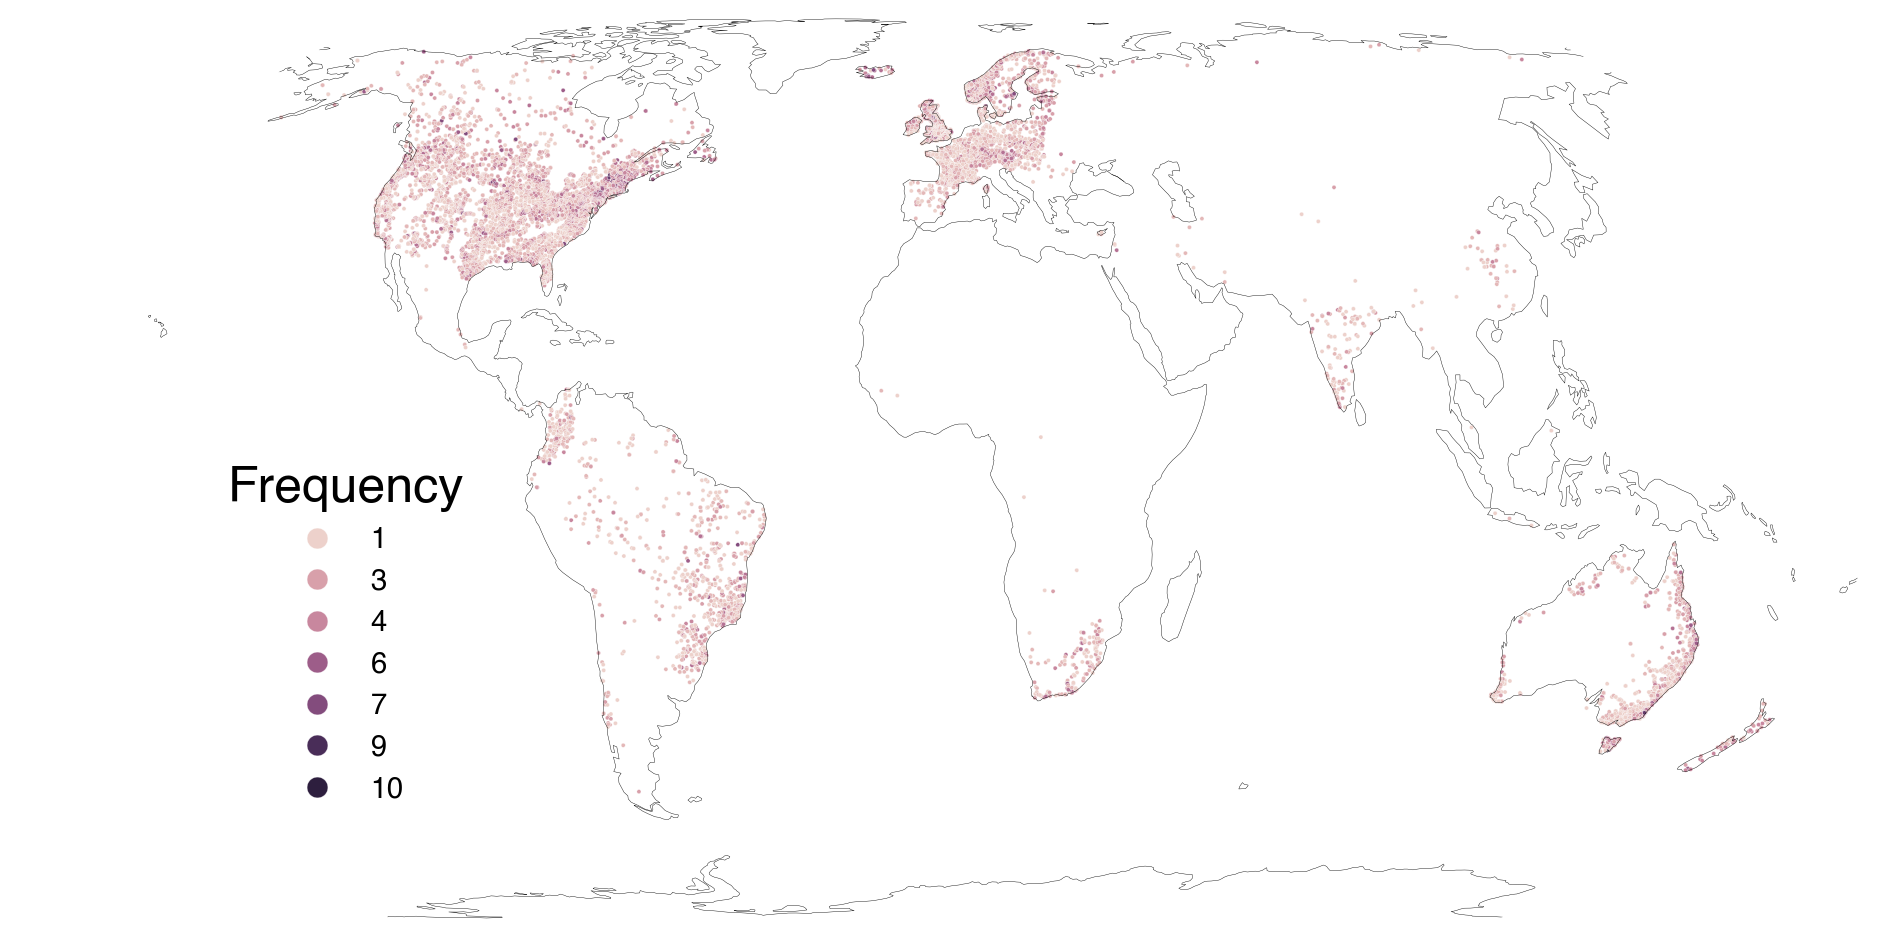

In [23]:
d2f_sta = d2f.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude']).d2f_x.count().reset_index()
fig, ax = plt.subplots(subplot_kw = {'projection':ccrs.EqualEarth()}, dpi = 300, figsize = (8,4))
ax.set_global()
ax.coastlines(lw = .1)
ax.spines['geo'].set_linewidth(0)
sns.scatterplot(d2f_sta,
               x = 'ohdb_longitude',
               y = 'ohdb_latitude',
               hue = 'd2f_x',
               ax = ax,
                s = 1,
               transform = ccrs.PlateCarree(),
               )
sns.move_legend(ax, 'lower left', bbox_to_anchor = (.1, .1), title = 'Frequency', title_fontsize = 12, markerscale = 5)

Text(0, 0.5, 'Number of drought-to-flood events')

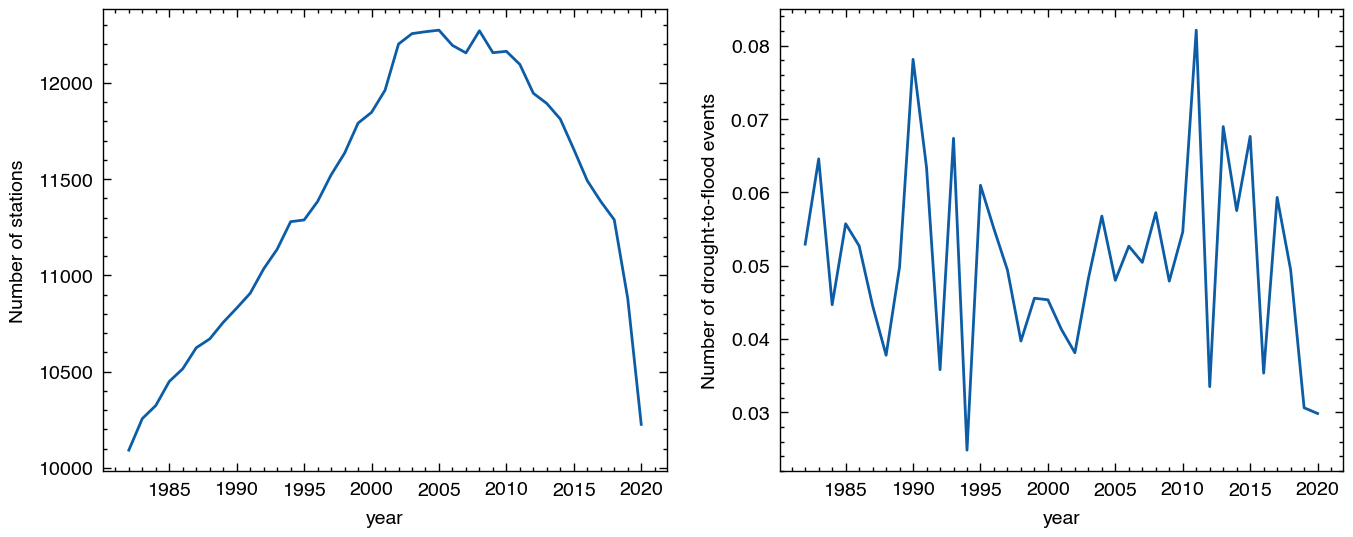

In [34]:
d2f['transition'] = (pd.to_datetime(d2f['start_y']) - pd.to_datetime(d2f['end_x'])).dt.days
d2f = d2f.loc[d2f.transition<=30,:]
d2f['year'] = pd.to_datetime(d2f['start_y']).dt.year
d2f_year = d2f.groupby('year')['ohdb_id'].count().reset_index()

event_year = pd.read_csv('number_stations_per_year.csv')
event_year = event_year.groupby('year').count().reset_index()
d2f_year = d2f_year.merge(event_year, on = 'year')
d2f_year['freq'] = d2f_year.ohdb_id_x / d2f_year.ohdb_id_y
d2f_year = d2f_year.loc[d2f_year.ohdb_id_y>=10000,:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3), dpi = 200)
sns.lineplot(d2f_year, x = 'year', y = 'ohdb_id_y', ax = ax1)
sns.lineplot(d2f_year, x = 'year', y = 'freq', ax = ax2)
ax1.set_ylabel('Number of stations')
ax2.set_ylabel('Number of drought-to-flood events')

### investigate poverty vs. drought-to-flood events

Mann_Kendall_Test(trend='no trend', h=False, p=0.9166614738418115, z=-0.10463999958144, Tau=-0.013513513513513514, s=-9.0, var_s=5845.0, slope=-6.179307159811774e-05, intercept=0.03769764114242465)


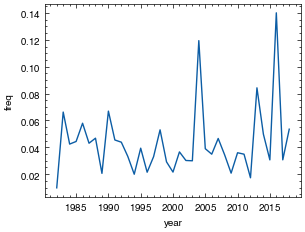

In [41]:
d2f_poor = d2f.loc[(d2f.ohdb_latitude>=-20)&(d2f.ohdb_latitude<=20),:]

event_year = pd.read_csv('number_stations_per_year.csv')
event_year = event_year.merge(df_attr[['ohdb_id','ohdb_longitude','ohdb_latitude']], on = 'ohdb_id')
event_year = event_year.loc[(event_year.ohdb_latitude>=-20)&(event_year.ohdb_latitude<=20),:]
event_year = event_year.groupby('year').ohdb_id.count().reset_index()
event_year = event_year.loc[event_year.ohdb_id>0,:]

d2f_poor = d2f_poor.groupby('year').ohdb_id.count().reset_index()
d2f_poor = d2f_poor.merge(event_year, on = 'year')
d2f_poor['freq'] = d2f_poor['ohdb_id_x'] / d2f_poor['ohdb_id_y']
d2f_poor = d2f_poor.loc[d2f_poor.year<=2018,:]

sns.lineplot(d2f_poor, x = 'year', y = 'freq')

import pymannkendall as mk
print(mk.original_test(d2f_poor.freq.values))

In [37]:
event_year

,year,ohdb_id
0,1982,1016
1,1983,1057
2,1984,1085
3,1985,1105
4,1986,1105
5,1987,1092
6,1988,1090
7,1989,1068
8,1990,1031
9,1991,1034
